<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span></li><li><span><a href="#Подготовка-данных-и-обучение-моделей" data-toc-modified-id="Подготовка-данных-и-обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка данных и обучение моделей</a></span></li><li><span><a href="#Итоговый-вывод" data-toc-modified-id="ЧИтоговый-вывод-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Итоговый вывод</a></span></li></ul></div>

# Снижение потребления электроэнергии при производстве стали

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали. 

Необходимо построить модель, которая предскажет температуру стали.

Целевой признак: последняя измеренная температура
Метрика: МАЕ. Качество 6.8 и ниже.

## План работы

1. Подготовка данных

   Загрузить данные, вывести первые строки. Получить обобщенную информацию о типах данных, пропусках, дублях, количестве строк.
    
    
2. Исследовательский анализ

    Обработать пропуски, выбросы, выявить/создать значимые признаки, объединить данные из разных наборов.
    Преобразовать типы, если требуется. Если необходимо, почистить дубли.
    
    
3. Модель
    
    Обучить несколько регрессионых моделей, подобрать лучшие параметры на кросс-валидации. 
    Проверить модели на адекватность с помощью константной модели.
    
    
4. Тестирование

    Проверить модель на тестовой выборке.
    
    
5. Выводы

    Итоговые выводы: качество и особенности данных, необходимые преобразования, используемые модели, лучшая модель.

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import os
import numpy as np
import time

import matplotlib.pyplot as plt

#from pyod.models.knn import KNN
from sklearn.ensemble import IsolationForest

import sklearn
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

## Обзор данных

Данные состоят из файлов, полученных из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

Взглянем на данные.

In [2]:
def get_data(path):
    if os.path.exists(path):
        data = pd.read_csv(path)
    else:
        splitted_str = path.split('/')        
        data = pd.read_csv(splitted_str[3])

    return data

In [3]:
def info_dataframe(data):
    print('Общая информация по dataframe:')
    print('')
    data.info()
    
    print('')
    print('Статистическая информация:')
    print('')
    display(data.describe().T)

In [4]:
# данные об электродах
data_arc = get_data('/datasets/final_steel/data_arc.csv')
data_arc

,key,Начало нагрева дугой,Конец нагрева дугой,Активная мощность,Реактивная мощность
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397
...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768


In [5]:
info_dataframe(data_arc)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14876 entries, 0 to 14875
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   key                   14876 non-null  int64  
 1   Начало нагрева дугой  14876 non-null  object 
 2   Конец нагрева дугой   14876 non-null  object 
 3   Активная мощность     14876 non-null  float64
 4   Реактивная мощность   14876 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 581.2+ KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,14876.0,1615.220422,934.571502,1.000000,806.000000,1617.000000,2429.000000,3241.000000
Активная мощность,14876.0,0.670441,0.408159,0.030002,0.395297,0.555517,0.857034,3.731596
Реактивная мощность,14876.0,0.452592,5.878702,-715.504924,0.290991,0.415962,0.637371,2.676388


Переименуем колонки.

In [6]:
data_arc = data_arc.rename(columns={'Начало нагрева дугой': 'start_time', 'Конец нагрева дугой': 'end_time', \
                   'Активная мощность': 'active', 'Реактивная мощность': 'reactive'})

Посмотрим, сколько строк с реактивной мощностью меньше 0.

In [7]:
data_arc.query('reactive < 0')

,key,start_time,end_time,active,reactive
9780,2116,2019-07-24 00:44:48,2019-07-24 00:46:37,0.495782,-715.504924


Выясним количество уникальных партий в наборе.

In [8]:
len(data_arc['key'].unique())

3214

Выясним, сколько строк может быть по партии.

In [9]:
pt_key_arc = pd.pivot_table(data_arc, index=['key'],
                   values=['start_time'],
                   aggfunc='count')
pt_key_arc.sort_values(by='start_time')['start_time'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

Выясним, есть ли дубли.

In [10]:
data_arc.duplicated().sum()

0

Построим гистограмму распределения значений мощностей.

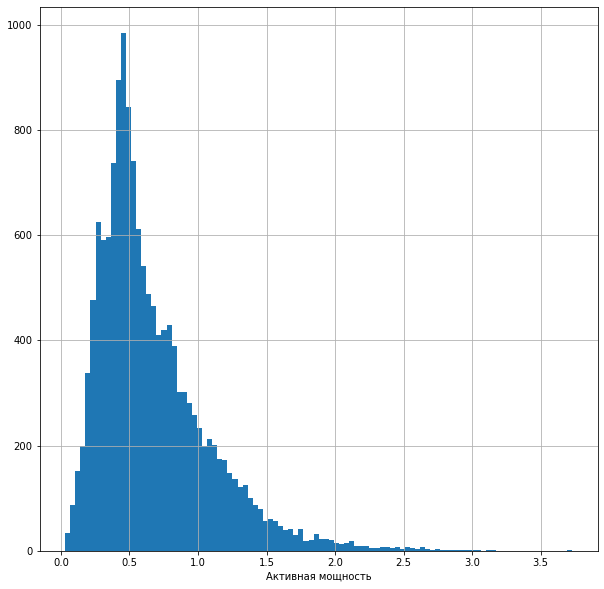

In [11]:
data_arc['active'].hist(figsize=(10, 10), bins=100).set_xlabel('Активная мощность');

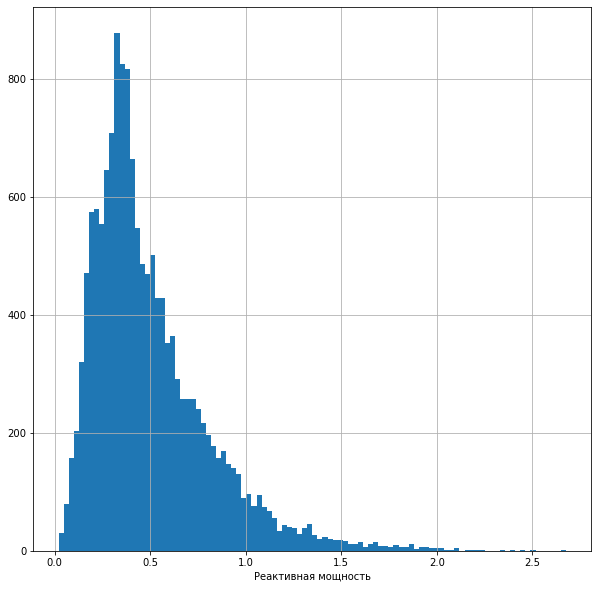

In [12]:
data_arc[data_arc['reactive'] > 0]['reactive'].hist(figsize=(10, 10), bins=100).set_xlabel('Реактивная мощность');

Пустых значений нет, полных дублей нет, датафрейм содержит информацию по 3214 партиям. Количество строк с информацией для каждой партии не одинаково: минимум 1 строка, максимум 16 строк.
По реактивной мощности есть одно некорректное отрицательное значение. На этапе обработки данных его необходимо удалить.
Время обработки хранится в столбце с типом object.

In [13]:
# данные о подаче сыпучих материалов (объём)
data_bulk = get_data('/datasets/final_steel/data_bulk.csv')
data_bulk

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,43.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,150.0,154.0
1,2,NaN,NaN,NaN,73.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,206.0,NaN,149.0,154.0
2,3,NaN,NaN,NaN,34.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,205.0,NaN,152.0,153.0
3,4,NaN,NaN,NaN,81.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,207.0,NaN,153.0,154.0
4,5,NaN,NaN,NaN,78.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,203.0,NaN,151.0,152.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,170.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,252.0,NaN,130.0,206.0
3125,3238,NaN,NaN,126.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,254.0,NaN,108.0,106.0
3126,3239,NaN,NaN,NaN,NaN,NaN,114.0,NaN,NaN,NaN,NaN,NaN,158.0,NaN,270.0,88.0
3127,3240,NaN,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,192.0,54.0


In [14]:
data_bulk.columns = data_bulk.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data_bulk = data_bulk.rename(columns={'ey': 'key'})

C:\Users\Вера\AppData\Local\Temp\ipykernel_2392\2765921204.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_bulk.columns = data_bulk.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [15]:
info_dataframe(data_bulk)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   key      3129 non-null   int64  
 1   bulk_1   252 non-null    float64
 2   bulk_2   22 non-null     float64
 3   bulk_3   1298 non-null   float64
 4   bulk_4   1014 non-null   float64
 5   bulk_5   77 non-null     float64
 6   bulk_6   576 non-null    float64
 7   bulk_7   25 non-null     float64
 8   bulk_8   1 non-null      float64
 9   bulk_9   19 non-null     float64
 10  bulk_10  176 non-null    float64
 11  bulk_11  177 non-null    float64
 12  bulk_12  2450 non-null   float64
 13  bulk_13  18 non-null     float64
 14  bulk_14  2806 non-null   float64
 15  bulk_15  2248 non-null   float64
dtypes: float64(15), int64(1)
memory usage: 391.2 KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.00,1622.0,2431.00,3241.0
bulk_1,252.0,39.242063,18.277654,10.0,27.00,31.0,46.00,185.0
bulk_2,22.0,253.045455,21.180578,228.0,242.00,251.5,257.75,325.0
bulk_3,1298.0,113.879045,75.483494,6.0,58.00,97.5,152.00,454.0
bulk_4,1014.0,104.394477,48.184126,12.0,72.00,102.0,133.00,281.0
bulk_5,77.0,107.025974,81.790646,11.0,70.00,86.0,132.00,603.0
bulk_6,576.0,118.925347,72.057776,17.0,69.75,100.0,157.00,503.0
bulk_7,25.0,305.600000,191.022904,47.0,155.00,298.0,406.00,772.0
bulk_8,1.0,49.000000,NaN,49.0,49.00,49.0,49.00,49.0
bulk_9,19.0,76.315789,21.720581,63.0,66.00,68.0,70.50,147.0


In [16]:
len(data_bulk['key'].unique())

3129

In [17]:
data_bulk.duplicated().sum()

0

In [18]:
data_bulk.drop(['key'], axis=1).isna().all(1).sum()

0

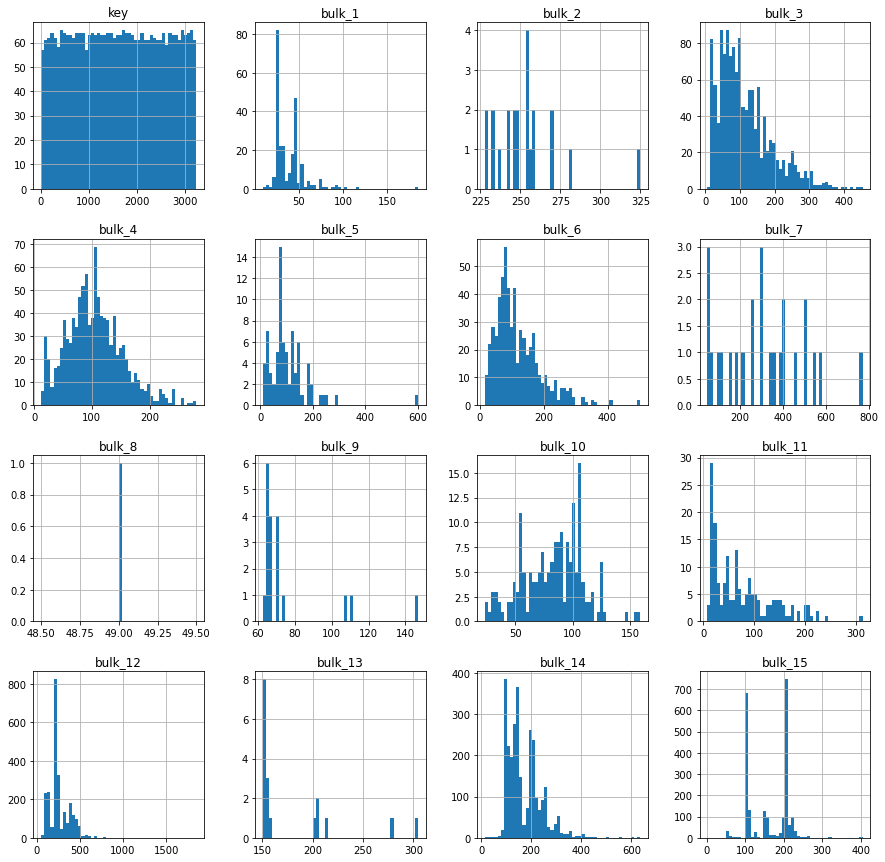

In [19]:
data_bulk.hist(figsize=(15, 15), bins=50);

В этом наборе данных меньше строк, чем в данных об электродах, значит, некоторые партии отсутствуют. Полных дублей нет, в каждой строке заполнено хотя бы одно значение подачи сыпучего матриала.
По гистограммам видно, что по некоторым материалам есть аномальные значения, а также по некоторым материалам есть тенденция к засыпанию кратного объема материала (50, 100, 200).

In [20]:
# данные о подаче сыпучих материалов (время)
data_bulk_time = get_data('/datasets/final_steel/data_bulk_time.csv')
data_bulk_time

,key,Bulk 1,Bulk 2,Bulk 3,Bulk 4,Bulk 5,Bulk 6,Bulk 7,Bulk 8,Bulk 9,Bulk 10,Bulk 11,Bulk 12,Bulk 13,Bulk 14,Bulk 15
0,1,NaN,NaN,NaN,2019-05-03 11:21:30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:03:52,NaN,2019-05-03 11:03:52,2019-05-03 11:03:52
1,2,NaN,NaN,NaN,2019-05-03 11:46:38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 11:40:20,NaN,2019-05-03 11:40:20,2019-05-03 11:40:20
2,3,NaN,NaN,NaN,2019-05-03 12:31:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:09:40,NaN,2019-05-03 12:09:40,2019-05-03 12:09:40
3,4,NaN,NaN,NaN,2019-05-03 12:48:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 12:41:24,NaN,2019-05-03 12:41:24,2019-05-03 12:41:24
4,5,NaN,NaN,NaN,2019-05-03 13:18:50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-05-03 13:12:56,NaN,2019-05-03 13:12:56,2019-05-03 13:12:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3124,3237,NaN,NaN,2019-08-31 22:51:28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 22:46:52,NaN,2019-08-31 22:46:52,2019-08-31 22:46:52
3125,3238,NaN,NaN,2019-08-31 23:39:11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-08-31 23:33:09,NaN,2019-08-31 23:33:09,2019-08-31 23:33:09
3126,3239,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:51:58,NaN,NaN,NaN,NaN,NaN,2019-09-01 01:39:41,NaN,2019-09-01 01:33:25,2019-09-01 01:33:25
3127,3240,NaN,NaN,NaN,NaN,NaN,2019-09-01 03:12:40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-09-01 02:41:27,2019-09-01 02:41:27


In [21]:
data_bulk_time.columns = data_bulk_time.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data_bulk_time = data_bulk_time.rename(columns={'ey': 'key'})

C:\Users\Вера\AppData\Local\Temp\ipykernel_2392\1328161882.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_bulk_time.columns = data_bulk_time.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [22]:
info_dataframe(data_bulk_time)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 16 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   key      3129 non-null   int64 
 1   bulk_1   252 non-null    object
 2   bulk_2   22 non-null     object
 3   bulk_3   1298 non-null   object
 4   bulk_4   1014 non-null   object
 5   bulk_5   77 non-null     object
 6   bulk_6   576 non-null    object
 7   bulk_7   25 non-null     object
 8   bulk_8   1 non-null      object
 9   bulk_9   19 non-null     object
 10  bulk_10  176 non-null    object
 11  bulk_11  177 non-null    object
 12  bulk_12  2450 non-null   object
 13  bulk_13  18 non-null     object
 14  bulk_14  2806 non-null   object
 15  bulk_15  2248 non-null   object
dtypes: int64(1), object(15)
memory usage: 391.2+ KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,3129.0,1624.383509,933.337642,1.0,816.0,1622.0,2431.0,3241.0


Некоторые сыпучие материалы засыпают одновременно. Строк столько же, сколько и в датасете с объемами сыпучих материалов, характер заполнения данных совпадает с датасетом по объемам материалов.

In [23]:
# данные о продувке сплава газом
data_gas = get_data('/datasets/final_steel/data_gas.csv')
data_gas

,key,Газ 1
0,1,29.749986
1,2,12.555561
2,3,28.554793
3,4,18.841219
4,5,5.413692
...,...,...
3234,3237,5.543905
3235,3238,6.745669
3236,3239,16.023518
3237,3240,11.863103


In [24]:
info_dataframe(data_gas)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3239 entries, 0 to 3238
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3239 non-null   int64  
 1   Газ 1   3239 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 50.7 KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,3239.0,1621.861377,935.386334,1.000000,812.500000,1622.000000,2431.500000,3241.00000
Газ 1,3239.0,11.002062,6.220327,0.008399,7.043089,9.836267,13.769915,77.99504


In [25]:
data_gas = data_gas.rename(columns={'Газ 1': 'gas_1'})

In [26]:
len(data_gas['key'].unique())

3239

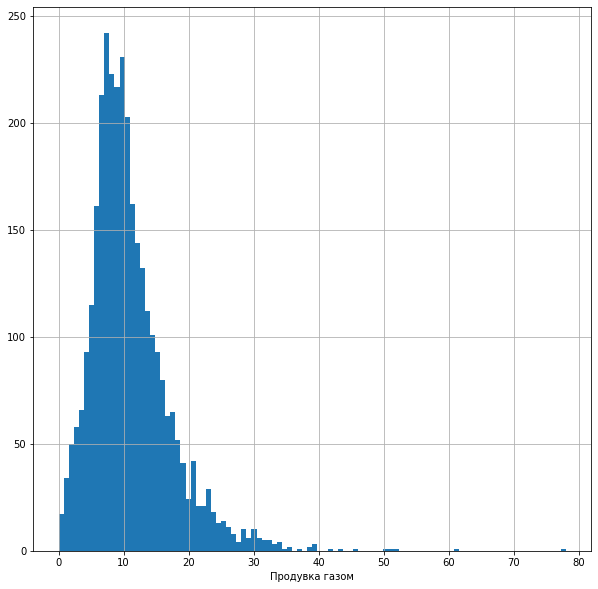

In [27]:
data_gas['gas_1'].hist(figsize=(10, 10), bins=100).set_xlabel('Продувка газом');

В датасете о продувке газом данные по 3239 уникальным партиям, на каждую партию по одной строке. Незаполненных значений нет.

In [28]:
# результаты измерения температуры
data_temp = get_data('/datasets/final_steel/data_temp.csv')
data_temp

,key,Время замера,Температура
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15902,3241,2019-09-01 04:03:30,1586.0
15903,3241,2019-09-01 04:16:12,NaN
15904,3241,2019-09-01 04:22:39,NaN
15905,3241,2019-09-01 04:33:42,NaN


In [29]:
data_temp = data_temp.rename(columns={'Время замера': 'time', 'Температура': 'temperature'})

In [30]:
info_dataframe(data_temp)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15907 entries, 0 to 15906
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   key          15907 non-null  int64  
 1   time         15907 non-null  object 
 2   temperature  13006 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 372.9+ KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,15907.0,1607.88087,942.212073,1.0,790.0,1618.0,2427.0,3241.0
temperature,13006.0,1591.84092,21.375851,1191.0,1581.0,1591.0,1601.0,1705.0


In [31]:
len(data_temp['key'].unique())

3216

Посмотрим, сколько данных по партиям пропадет после очистки строк с пустыми значениями температуры.

In [32]:
data_temp.query('temperature == temperature')

,key,time,temperature
0,1,2019-05-03 11:16:18,1571.0
1,1,2019-05-03 11:25:53,1604.0
2,1,2019-05-03 11:29:11,1618.0
3,1,2019-05-03 11:30:01,1601.0
4,1,2019-05-03 11:30:39,1613.0
...,...,...,...
15878,3237,2019-08-31 22:44:04,1569.0
15883,3238,2019-08-31 23:30:31,1584.0
15886,3239,2019-09-01 01:31:47,1598.0
15894,3240,2019-09-01 02:39:01,1617.0


In [33]:
len(data_temp.query('temperature == temperature')['key'].unique())

3216

Данные по партиям не очистились, строки с пустыми значениями температуры можно удалить без потери важных данных.

In [34]:
data_temp = data_temp.query('temperature == temperature')

Возможное количество строк в разрезе партии:

In [35]:
pt_key_temp = pd.pivot_table(data_temp, index=['key'],
                   values=['temperature'],
                   aggfunc='count')
pt_key_temp.sort_values(by='temperature')['temperature'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16],
      dtype=int64)

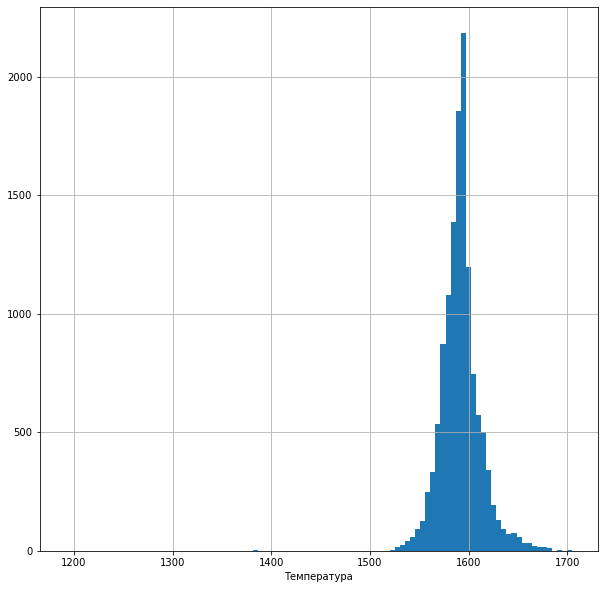

In [36]:
data_temp['temperature'].hist(figsize=(10, 10), bins=100).set_xlabel('Температура');

В датасете с результатами измерения температуры содержатся данные по 3216 уникальным партиям. Есть строки с незаполненной температурой, их можно удалить.

In [37]:
# данные о проволочных материалах (объём)
data_wire = get_data('/datasets/final_steel/data_wire.csv')
data_wire

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,38.088959,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,56.128799,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,143.357761,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,34.070400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
data_wire.columns = data_wire.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data_wire = data_wire.rename(columns={'ey': 'key'})

C:\Users\Вера\AppData\Local\Temp\ipykernel_2392\2892140398.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_wire.columns = data_wire.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [39]:
info_dataframe(data_wire)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   key     3081 non-null   int64  
 1   wire_1  3055 non-null   float64
 2   wire_2  1079 non-null   float64
 3   wire_3  63 non-null     float64
 4   wire_4  14 non-null     float64
 5   wire_5  1 non-null      float64
 6   wire_6  73 non-null     float64
 7   wire_7  11 non-null     float64
 8   wire_8  19 non-null     float64
 9   wire_9  29 non-null     float64
dtypes: float64(9), int64(1)
memory usage: 240.8 KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.000000,823.000000,1619.000000,2434.000000,3241.000000
wire_1,3055.0,100.895853,42.012518,1.918800,72.115684,100.158234,126.060483,330.314424
wire_2,1079.0,50.577323,39.320216,0.030160,20.193680,40.142956,70.227558,282.780152
wire_3,63.0,189.482681,99.513444,0.144144,95.135044,235.194977,276.252014,385.008668
wire_4,14.0,57.442842,28.824667,24.148801,40.807002,45.234282,76.124619,113.231044
wire_5,1.0,15.132000,NaN,15.132000,15.132000,15.132000,15.132000,15.132000
wire_6,73.0,48.016974,33.919845,0.034320,25.053600,42.076324,64.212723,180.454575
wire_7,11.0,10.039007,8.610584,0.234208,6.762756,9.017009,11.886057,32.847674
wire_8,19.0,53.625193,16.881728,45.076721,46.094879,46.279999,48.089603,102.762401
wire_9,29.0,34.155752,19.931616,4.622800,22.058401,30.066399,43.862003,90.053604


In [40]:
len(data_wire['key'].unique())

3081

In [41]:
data_wire.drop(['key'], axis=1).isna().all(1).sum()

0

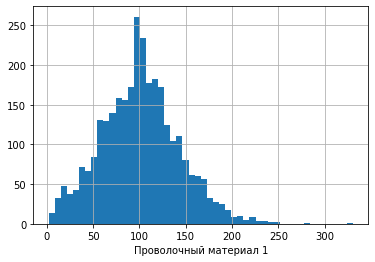

In [42]:
data_wire['wire_1'].hist(bins=50).set_xlabel('Проволочный материал 1');

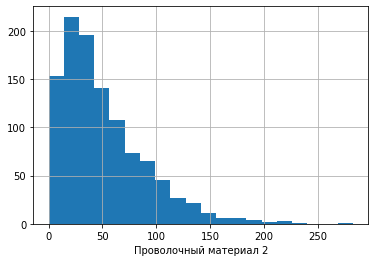

In [43]:
data_wire['wire_2'].hist(bins=20).set_xlabel('Проволочный материал 2');

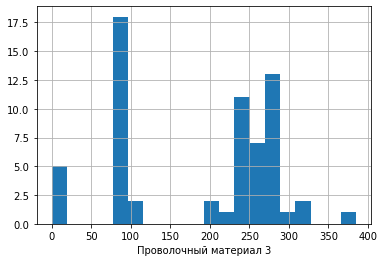

In [44]:
data_wire['wire_3'].hist(bins=20).set_xlabel('Проволочный материал 3');

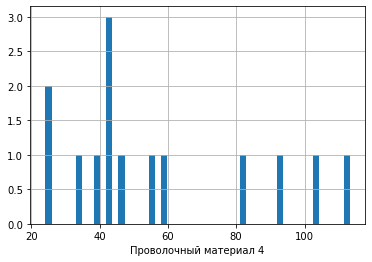

In [45]:
data_wire['wire_4'].hist(bins=50).set_xlabel('Проволочный материал 4');

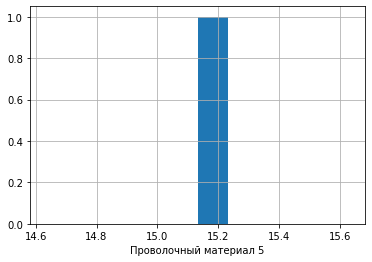

In [46]:
data_wire['wire_5'].hist(bins=10).set_xlabel('Проволочный материал 5');

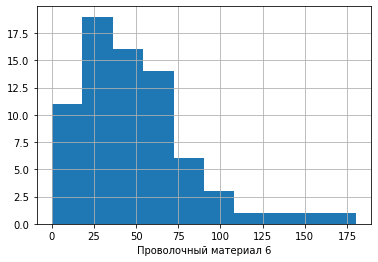

In [47]:
data_wire['wire_6'].hist(bins=10).set_xlabel('Проволочный материал 6');

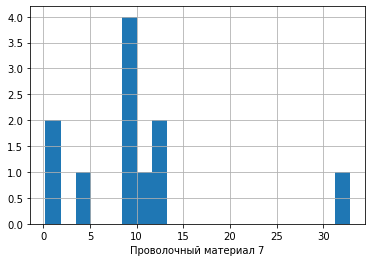

In [48]:
data_wire['wire_7'].hist(bins=20).set_xlabel('Проволочный материал 7');

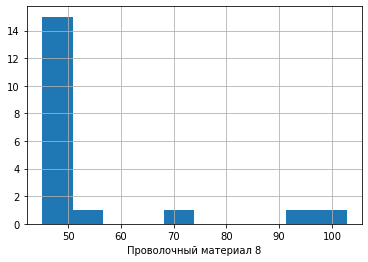

In [49]:
data_wire['wire_8'].hist(bins=10).set_xlabel('Проволочный материал 8');

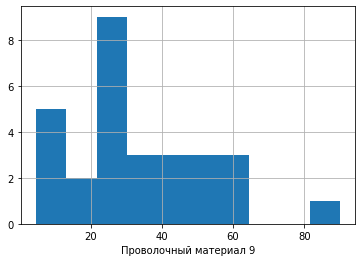

In [50]:
data_wire['wire_9'].hist(bins=10).set_xlabel('Проволочный материал 9');

В датасете с объемом проволочных материалов меньше всего данных по партиям: 3081 уникальная партия, на партию по строке. В строке заполнено хотя бы одно значение по материалу. Есть более и менее используемые материалы аналогично с сыпучими материалами. Также есть выбросы и аномалии.

In [51]:
# данные о проволочных материалах (время)
data_wire_time = get_data('/datasets/final_steel/data_wire_time.csv')
data_wire_time

,key,Wire 1,Wire 2,Wire 3,Wire 4,Wire 5,Wire 6,Wire 7,Wire 8,Wire 9
0,1,2019-05-03 11:11:41,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,2019-05-03 11:46:10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2019-05-03 12:13:47,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,2019-05-03 12:48:05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,2019-05-03 13:18:15,2019-05-03 13:32:06,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3076,3237,2019-08-31 22:50:20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3077,3238,2019-08-31 23:38:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3078,3239,2019-09-01 01:50:43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3079,3240,2019-09-01 03:12:02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [52]:
data_wire_time.columns = data_wire_time.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
data_wire_time = data_wire_time.rename(columns={'ey': 'key'})

C:\Users\Вера\AppData\Local\Temp\ipykernel_2392\758213258.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  data_wire_time.columns = data_wire_time.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


In [53]:
info_dataframe(data_wire_time)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3081 entries, 0 to 3080
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   key     3081 non-null   int64 
 1   wire_1  3055 non-null   object
 2   wire_2  1079 non-null   object
 3   wire_3  63 non-null     object
 4   wire_4  14 non-null     object
 5   wire_5  1 non-null      object
 6   wire_6  73 non-null     object
 7   wire_7  11 non-null     object
 8   wire_8  19 non-null     object
 9   wire_9  29 non-null     object
dtypes: int64(1), object(9)
memory usage: 240.8+ KB

Статистическая информация:



,count,mean,std,min,25%,50%,75%,max
key,3081.0,1623.426485,932.996726,1.0,823.0,1619.0,2434.0,3241.0


In [54]:
len(data_wire_time['key'].unique())

3081

Строк столько же, сколько и в датасете с объемами проволочных материалов, характер заполнения данных совпадает с датасетом по объемам материалов.

### Выводы по обзору данных

1. Датафреймы содержат данные по разному количеству партий: возможно часть партий прошла не весь технологический процесс или часть данных утеряна. При подготовке данных будут учтены данные по партиям с полными данными.

2. По датам соединить датафреймы не представляется возможным: в каких-то случаях замер происходил до засыпания/добавления материалов, в каких-то после. Датафреймы будут соединены по ключу key, т.е. по партии.

3. Данные по мощностям, температуре и продувке газом распределены нормально со смещениями. Данные по некоторым материалам также распределены нормально, по остальным не так много данных.

3. В данных есть выбросы, незаполненные значения, отрицательные значения. Строки с пустым замером температуры удалены: данные по температуре остались по всем партиям. Отрицательное значение по реактивной мощности будет удалено. От выбросов очистим обучающую выборку.

4. В некоторых таблицах на партию приходится одна строка, в некоторых несколько (данные о нагреве электродами и данные о замерах).

5. Время во всех таблицах хранится в столбцах с типом object, необходимо преобразовать столбцы в datetime. но не все данные нужны для обучения модели: данные о времени засыпания/добавления материалов не нужны, поскольку регресионные модели не работают с датами. Генерация новых признаков на основе этих данных не обоснована.

6. Целевой признак - температура последнего измерения. Необходимо найти эту строку в таблице с измерениями температуры. В таблице с данными по электродам необходимо сгруппировать строки, т.к. интересна суммарная мощность, а не мощность в разрезе измерений. Время изменерений в таблице с данными по электродам не сопоставляется напрямую со временем в таблице измерений температуры.

Были преобразованы имена колонок датафреймов для удобства при дальнейшем анализе.

## Анализ данных

Поскольку целевой признак - это температура последнего измерения, необходимо подготовить таблицы с данными об электродах и измерениях температуры.

Удалим некорректную строку из данных об электродах.

In [55]:
data_arc = data_arc.query('reactive > 0')

Преобразуем даты в таблице с данными об электродах и вычислим время нагрева в секундах - это будет новый признак, с которым будет работать модель.

In [56]:
data_arc['start_time'] = pd.to_datetime(data_arc['start_time'], format='%Y-%m-%d')
data_arc['end_time'] = pd.to_datetime(data_arc['end_time'], format='%Y-%m-%d')
data_arc['time_diff'] = (data_arc['end_time'] - data_arc['start_time']).dt.seconds

In [57]:
data_arc

,key,start_time,end_time,active,reactive,time_diff
0,1,2019-05-03 11:02:14,2019-05-03 11:06:02,0.976059,0.687084,228
1,1,2019-05-03 11:07:28,2019-05-03 11:10:33,0.805607,0.520285,185
2,1,2019-05-03 11:11:44,2019-05-03 11:14:36,0.744363,0.498805,172
3,1,2019-05-03 11:18:14,2019-05-03 11:24:19,1.659363,1.062669,365
4,1,2019-05-03 11:26:09,2019-05-03 11:28:37,0.692755,0.414397,148
...,...,...,...,...,...,...
14871,3241,2019-09-01 03:58:58,2019-09-01 04:01:35,0.533670,0.354439,157
14872,3241,2019-09-01 04:05:04,2019-09-01 04:08:04,0.676604,0.523631,180
14873,3241,2019-09-01 04:16:41,2019-09-01 04:19:45,0.733899,0.475654,184
14874,3241,2019-09-01 04:31:51,2019-09-01 04:32:48,0.220694,0.145768,57


Посмотрим на праспределение времени нагрева в секундах.

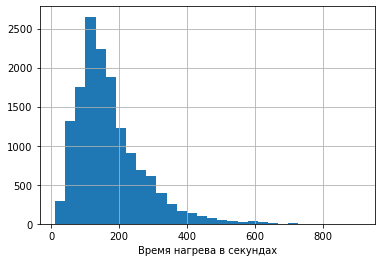

In [58]:
data_arc['time_diff'].hist(bins=30).set_xlabel('Время нагрева в секундах');

Время нагрева распределено нормально, чаще всего электроды включают на ~100 сек.

Получим время первого нагрева для партии и время последнего нагрева. Данные по мощностям суммируем в разрезе партии.

In [59]:
pt_time = pd.pivot_table(data_arc, index=['key'],
                   values=['start_time', 'end_time'],
                   aggfunc=['min', 'max'])
pt_time.columns = ['min_end_time', 'min_start_time', 'max_end_time', 'max_start_time']
pt_time

,min_end_time,min_start_time,max_end_time,max_start_time
key,,,,
1,2019-05-03 11:06:02,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:26:09
2,2019-05-03 11:36:31,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:49:48
3,2019-05-03 12:11:34,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:31:14
4,2019-05-03 12:43:04,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:53:12
5,2019-05-03 13:15:24,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:32:44
...,...,...,...,...
3237,2019-08-31 22:43:17,2019-08-31 22:41:18,2019-08-31 23:03:48,2019-08-31 23:01:32
3238,2019-08-31 23:28:09,2019-08-31 23:26:18,2019-08-31 23:41:28,2019-08-31 23:38:38
3239,2019-09-01 01:29:20,2019-09-01 01:26:53,2019-09-01 02:15:43,2019-09-01 02:13:38


In [60]:
pt_power = pd.pivot_table(data_arc, index=['key'],
                   values=['active', 'reactive', 'time_diff'],
                   aggfunc='sum')
pt_power

,active,reactive,time_diff
key,,,
1,4.878147,3.183241,1098
2,3.052598,1.998112,811
3,2.525882,1.599076,655
4,3.209250,2.060298,741
5,3.347173,2.252643,869
...,...,...,...
3237,3.932467,2.828459,909
3238,2.106529,1.681182,546
3239,4.666754,3.111617,1216


In [61]:
data_arc_tr = pt_power.merge(pt_time, on='key')
data_arc_tr = data_arc_tr.drop(['min_end_time', 'max_start_time'], axis=1)

Взглянем на свернутую таблицу по электродам.

In [62]:
data_arc_tr

,active,reactive,time_diff,min_start_time,max_end_time
key,,,,,
1,4.878147,3.183241,1098,2019-05-03 11:02:14,2019-05-03 11:28:37
2,3.052598,1.998112,811,2019-05-03 11:34:14,2019-05-03 11:53:18
3,2.525882,1.599076,655,2019-05-03 12:06:54,2019-05-03 12:32:19
4,3.209250,2.060298,741,2019-05-03 12:39:37,2019-05-03 12:57:50
5,3.347173,2.252643,869,2019-05-03 13:11:13,2019-05-03 13:33:55
...,...,...,...,...,...
3237,3.932467,2.828459,909,2019-08-31 22:41:18,2019-08-31 23:03:48
3238,2.106529,1.681182,546,2019-08-31 23:26:18,2019-08-31 23:41:28
3239,4.666754,3.111617,1216,2019-09-01 01:26:53,2019-09-01 02:15:43


Преобразуем данные по замерам.

Возьмем время начала и время окончания замеров внутри партии и начальную и конечную температуру партии.

In [63]:
data_temp['time'] = pd.to_datetime(data_temp['time'], format='%Y-%m-%d')

In [64]:
pt_time_temp= pd.pivot_table(data_temp, index=['key'],
                   values=['time'],
                   aggfunc=['min', 'max'])
pt_time_temp.columns = ['min_time', 'max_time']
pt_time_temp

,min_time,max_time
key,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39
2,2019-05-03 11:37:27,2019-05-03 11:59:12
3,2019-05-03 12:13:17,2019-05-03 12:34:57
4,2019-05-03 12:52:57,2019-05-03 12:59:25
5,2019-05-03 13:23:19,2019-05-03 13:36:01
...,...,...
3237,2019-08-31 22:44:04,2019-08-31 22:44:04
3238,2019-08-31 23:30:31,2019-08-31 23:30:31
3239,2019-09-01 01:31:47,2019-09-01 01:31:47


In [65]:
pt_time_temp1 = pd.pivot_table(data_temp, index=['key'],
                   values=['temperature'],
                   aggfunc=['first', 'last'])
pt_time_temp1.columns = ['start_temp', 'end_temp']
pt_time_temp1

,start_temp,end_temp
key,,
1,1571.0,1613.0
2,1581.0,1602.0
3,1596.0,1599.0
4,1601.0,1625.0
5,1576.0,1602.0
...,...,...
3237,1569.0,1569.0
3238,1584.0,1584.0
3239,1598.0,1598.0


Взглянем на итоговую таблицу по измерению температуры.

In [66]:
data_temp_tr = pt_time_temp.merge(pt_time_temp1, on='key')
data_temp_tr

,min_time,max_time,start_temp,end_temp
key,,,,
1,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...
3237,2019-08-31 22:44:04,2019-08-31 22:44:04,1569.0,1569.0
3238,2019-08-31 23:30:31,2019-08-31 23:30:31,1584.0,1584.0
3239,2019-09-01 01:31:47,2019-09-01 01:31:47,1598.0,1598.0


Видно, что для некоторых партий был всего один замер времени (например, 3237, 3238), такие партии бесполезны для исследования.
Также в некоторых случаях время последнего замера раньше, чем время окончания работы электродов - такие данные тоже не валидны.

In [67]:
date_arc_temp = data_arc_tr.merge(data_temp_tr, on='key') # смерджим таблицы
date_arc_temp = date_arc_temp.query('min_time != max_time') # удаляем строки, где совпадает время начала и окончания замера
date_arc_temp = date_arc_temp.query('start_temp != end_temp') # удаляем строки, где совпадает температура начала и окончания замера
date_arc_temp

,active,reactive,time_diff,min_start_time,max_end_time,min_time,max_time,start_temp,end_temp
key,,,,,,,,,
1,4.878147,3.183241,1098,2019-05-03 11:02:14,2019-05-03 11:28:37,2019-05-03 11:16:18,2019-05-03 11:30:39,1571.0,1613.0
2,3.052598,1.998112,811,2019-05-03 11:34:14,2019-05-03 11:53:18,2019-05-03 11:37:27,2019-05-03 11:59:12,1581.0,1602.0
3,2.525882,1.599076,655,2019-05-03 12:06:54,2019-05-03 12:32:19,2019-05-03 12:13:17,2019-05-03 12:34:57,1596.0,1599.0
4,3.209250,2.060298,741,2019-05-03 12:39:37,2019-05-03 12:57:50,2019-05-03 12:52:57,2019-05-03 12:59:25,1601.0,1625.0
5,3.347173,2.252643,869,2019-05-03 13:11:13,2019-05-03 13:33:55,2019-05-03 13:23:19,2019-05-03 13:36:01,1576.0,1602.0
...,...,...,...,...,...,...,...,...,...
2495,3.210690,2.360777,723,2019-08-06 00:31:05,2019-08-06 00:51:13,2019-08-06 00:35:45,2019-08-06 00:54:42,1570.0,1591.0
2496,4.203064,2.810185,940,2019-08-06 01:00:06,2019-08-06 01:23:32,2019-08-06 01:02:54,2019-08-06 01:29:52,1554.0,1591.0
2497,2.212379,1.851269,569,2019-08-06 01:38:01,2019-08-06 01:50:45,2019-08-06 01:41:53,2019-08-06 01:53:50,1571.0,1589.0


In [68]:
date_arc_temp = date_arc_temp.drop(['min_start_time', 'max_end_time', 'min_time', 'max_time'], axis=1)

In [69]:
date_arc_temp

,active,reactive,time_diff,start_temp,end_temp
key,,,,,
1,4.878147,3.183241,1098,1571.0,1613.0
2,3.052598,1.998112,811,1581.0,1602.0
3,2.525882,1.599076,655,1596.0,1599.0
4,3.209250,2.060298,741,1601.0,1625.0
5,3.347173,2.252643,869,1576.0,1602.0
...,...,...,...,...,...
2495,3.210690,2.360777,723,1570.0,1591.0
2496,4.203064,2.810185,940,1554.0,1591.0
2497,2.212379,1.851269,569,1571.0,1589.0


Теперь можно присоединить остальные таблицы.

In [70]:
data_common = date_arc_temp.merge(data_bulk, on='key')
data_common = data_common.merge(data_gas, on='key')
data_common = data_common.merge(data_wire, on='key')

data_common

,key,active,reactive,time_diff,start_temp,end_temp,bulk_1,bulk_2,bulk_3,bulk_4,...,gas_1,wire_1,wire_2,wire_3,wire_4,wire_5,wire_6,wire_7,wire_8,wire_9
0,1,4.878147,3.183241,1098,1571.0,1613.0,NaN,NaN,NaN,43.0,...,29.749986,60.059998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,3.052598,1.998112,811,1581.0,1602.0,NaN,NaN,NaN,73.0,...,12.555561,96.052315,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,2.525882,1.599076,655,1596.0,1599.0,NaN,NaN,NaN,34.0,...,28.554793,91.160157,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,3.209250,2.060298,741,1601.0,1625.0,NaN,NaN,NaN,81.0,...,18.841219,89.063515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,3.347173,2.252643,869,1576.0,1602.0,NaN,NaN,NaN,78.0,...,5.413692,89.238236,9.11456,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,2495,3.210690,2.360777,723,1570.0,1591.0,NaN,NaN,21.0,NaN,...,7.125735,89.150879,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2289,2496,4.203064,2.810185,940,1554.0,1591.0,NaN,NaN,NaN,63.0,...,9.412616,114.179527,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2290,2497,2.212379,1.851269,569,1571.0,1589.0,NaN,NaN,NaN,85.0,...,6.271699,94.086723,9.04800,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2291,2498,3.408725,2.355428,750,1591.0,1594.0,NaN,NaN,90.0,NaN,...,14.953657,118.110717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Взглянем на объединенную таблицу.

In [71]:
info_dataframe(data_common)

Общая информация по dataframe:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2293 entries, 0 to 2292
Data columns (total 31 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   key         2293 non-null   int64  
 1   active      2293 non-null   float64
 2   reactive    2293 non-null   float64
 3   time_diff   2293 non-null   int64  
 4   start_temp  2293 non-null   float64
 5   end_temp    2293 non-null   float64
 6   bulk_1      197 non-null    float64
 7   bulk_2      13 non-null     float64
 8   bulk_3      950 non-null    float64
 9   bulk_4      796 non-null    float64
 10  bulk_5      53 non-null     float64
 11  bulk_6      432 non-null    float64
 12  bulk_7      13 non-null     float64
 13  bulk_8      1 non-null      float64
 14  bulk_9      13 non-null     float64
 15  bulk_10     142 non-null    float64
 16  bulk_11     126 non-null    float64
 17  bulk_12     1785 non-null   float64
 18  bulk_13     14 non-null     float64


,count,mean,std,min,25%,50%,75%,max
key,2293.0,1249.383777,715.286078,1.000000,627.000000,1251.000000,1865.000000,2499.000000
active,2293.0,3.159618,1.427323,0.186226,2.190623,3.034115,3.928126,17.496497
reactive,2293.0,2.355581,1.083146,0.158247,1.628309,2.240437,2.924655,12.587990
time_diff,2293.0,809.085478,341.310743,57.000000,585.000000,780.000000,995.000000,4189.000000
start_temp,2293.0,1586.618404,28.457503,1191.000000,1571.000000,1586.000000,1603.000000,1660.000000
end_temp,2293.0,1593.369385,11.179055,1541.000000,1587.000000,1593.000000,1598.000000,1653.000000
bulk_1,197.0,40.015228,18.286963,10.000000,27.000000,31.000000,46.000000,185.000000
bulk_2,13.0,254.846154,25.973853,228.000000,242.000000,248.000000,258.000000,325.000000
bulk_3,950.0,115.003158,77.646961,6.000000,57.250000,96.500000,152.750000,454.000000
bulk_4,796.0,107.056533,49.243669,13.000000,73.000000,105.000000,137.000000,281.000000


Колонка wire_5 теперь осталась пустой, удалим ее.

In [72]:
data_common = data_common.drop(['wire_5'], axis=1)

In [73]:
pd.DataFrame(round(data_common.isna().mean()*100,)).style.background_gradient('coolwarm')

,0
key,0.000000
active,0.000000
reactive,0.000000
time_diff,0.000000
start_temp,0.000000
end_temp,0.000000
bulk_1,91.000000
bulk_2,99.000000
bulk_3,59.000000
bulk_4,65.000000


Проверим, коррелируют ли признаки между собой. Сильная корреляция независимых признаков (мультиколлениарность) может стать причиной переобучения линейных моделей.

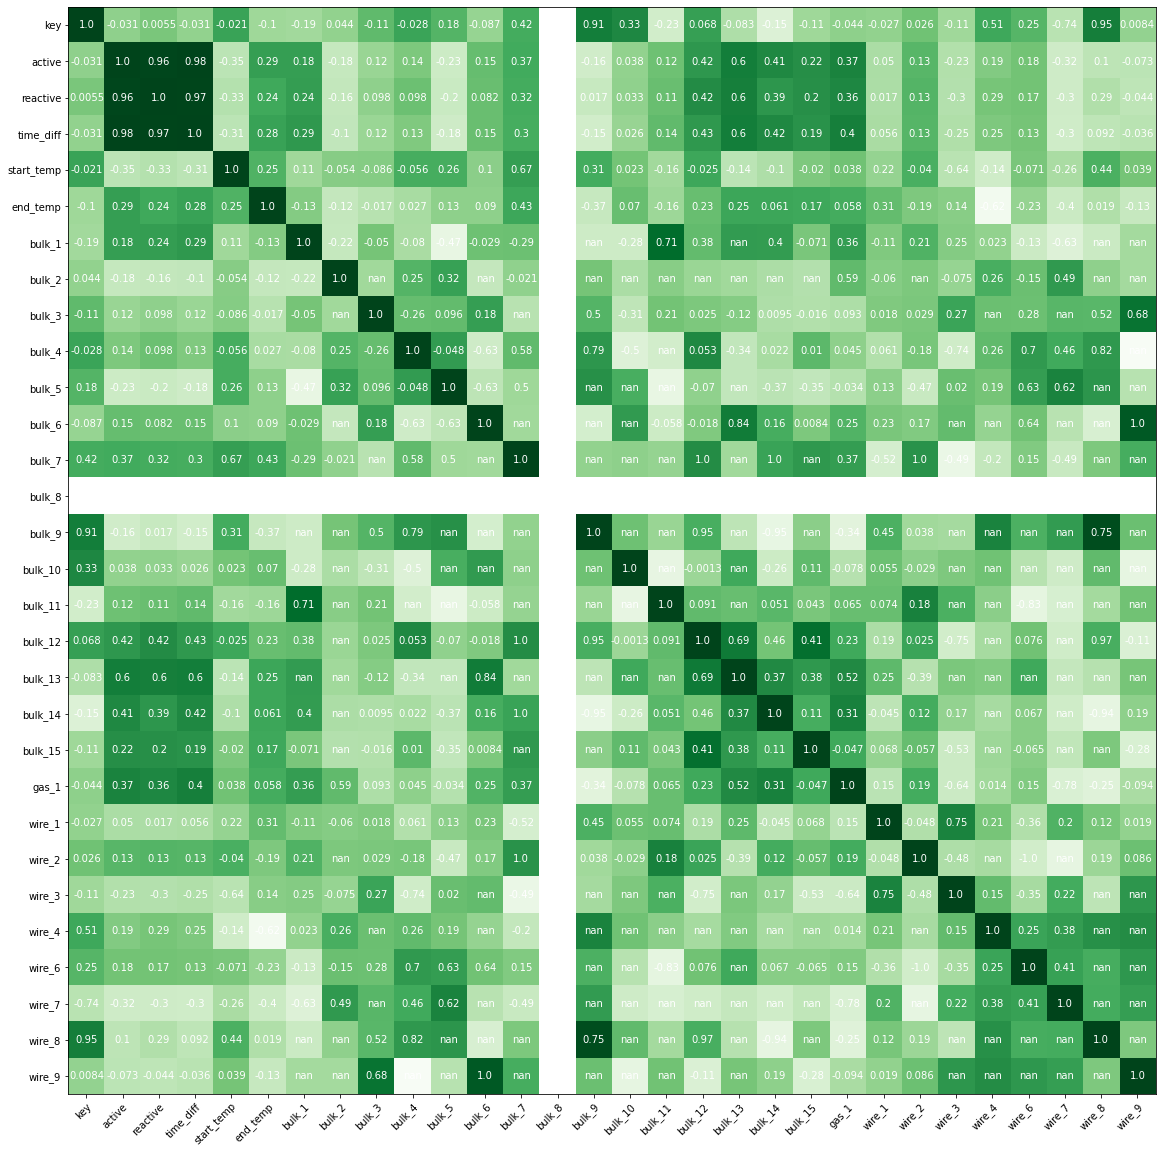

In [74]:
data_corr = data_common.corr()

fig, ax = plt.subplots(figsize=(20,20))
ax.set_xticks(np.arange(len(data_corr.index)))
ax.set_yticks(np.arange(len(data_corr.index)))

ax.set_xticklabels(data_corr.index)
ax.set_yticklabels(data_corr.index)

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

data = data_corr.values

for i in range(len(data_corr.index)):
    for j in range(len(data_corr.index)):
        text = ax.text(j, i, '{:.2}'.format(data[i, j]),
                       ha="center", va="center", color="w")
        
im = ax.imshow(data_corr.corr(), cmap='Greens')


Из heatmap видна сильная корреляция между активной и реактивной мощностью, а также между мощностями и временем нагрева электродуг. Оставим для модели только признак с активной мощностью.

Также есть сильная корреляция между признаками:
- wire_9 и bulk_6
- wire_8 и bulk_12.
- bulk_9 и bulk_12.
На грани допустимого корреляция между признаками wire_8 и bulk_9. Оба столбца содержат большое количество незаполненных значений. Удалим столбец bulk_9.
Удалим признак wire_9, в нем к тому же очень мало заполненных значений. 

С целевым признаком сильных корреляций нет.

In [75]:
data_common = data_common.drop(['reactive', 'time_diff', 'wire_9', 'bulk_9', 'bulk_12'], axis=1)

Отсутствующие значения заменим нулями.

In [76]:
data_common = data_common.fillna(0)

### Выводы по анализу данных

1. Данные были преобразованы для анализа последней температуры замеры: сгруппированы данные в таблицах с информацией по нагреву электродов и с результатами измерений температуры.

2. Были удалены некорректные данные: 
- строки, где времена измерения температуры и времени нагрева дуги не совпадали
- строки с одним замером
- строки, отсутствующие в других наборах.

3. Была проанализирована корреляция между признаками, сильно коррелирующие признаки были удалены.

4. Отсутсвующие значения заменены нулями.

# Подготовка данных и обучение моделей

Разделим данные на признаки и целовой признак.

In [77]:
features = data_common.drop(['end_temp'], axis = 1)
target = data_common['end_temp']

Подготовим выборки для обучения.

In [78]:
features_train, features_test = train_test_split(features, test_size=0.25, random_state=270323)
target_train, target_test = train_test_split(target, test_size=0.25, random_state=270323)

In [79]:
numeric_columns = ['active', 'start_temp', 'bulk_1', 'bulk_2', 'bulk_3', 'bulk_4',
       'bulk_5', 'bulk_6', 'bulk_7', 'bulk_8', 'bulk_10', 'bulk_11', 'bulk_13',
       'bulk_14', 'bulk_15', 'gas_1', 'wire_1', 'wire_2', 'wire_3', 'wire_4',
       'wire_6', 'wire_7', 'wire_8']

Удалим аномалии из обучающей выборки, тестовую не изменяем. Модель должна быть протестирована и успешно работать и на данных с аномалиями.

In [81]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(n_estimators=100)
estimator = isolation_forest.fit_predict(features_train[numeric_columns])

outliers = list(filter(lambda x: x == -1, estimator))
print("Количество аномалий:", len(outliers))

Количество аномалий: 25


In [82]:
print("Процент аномалий:", round(len(outliers) / features_train.shape[0] * 100, 2))

Процент аномалий: 1.45


In [83]:
features_train['is_outlier'] =  estimator == -1
features_train = features_train[features_train['is_outlier'] == False] 
target_train = target_train[features_train.index] 

features_train = features_train.drop(['is_outlier'], axis=1)

Масштабируем признаки для линейных моделей.

In [86]:
features_train_not_scaled = features_train.copy()
features_test_not_scaled = features_test.copy()

scaler = StandardScaler()
scaler.fit(features_train[numeric_columns])
features_train[numeric_columns] = scaler.transform(features_train[numeric_columns])
features_test[numeric_columns] = scaler.transform(features_test[numeric_columns])

Обучим несколько моделей:
1. LinearRegression
2. Ridge
3. Lasso
4. LightGBM

И сравним результаты с dummy моделью.

### LinearRegression

In [87]:
%%time
model_lr = LinearRegression()

start_time_lr = time.time()

scores = cross_val_score(model_lr, features_train, target_train, cv=5, scoring='neg_mean_absolute_error')
end_time_lr = time.time()
time_lr = end_time_lr - start_time_lr

scores_mean = pd.Series(scores).mean()

print('Время расчета:', round(time_lr * 1000, 2), 'ms /', round(time_lr, 2), 'sec')
print('Значение mae для модели линейной регрессии:', -round(scores_mean, 2))

Время расчета: 41.28 ms / 0.04 sec
Значение mae для модели линейной регрессии: 6.25
CPU times: total: 31.2 ms
Wall time: 41.3 ms


In [88]:
print(f"MAE {- round(scores_mean, 2)} удовлетворяет требуемому показателю, скорость обучения очень маленькая.")

MAE 6.25 удовлетворяет требуемому показателю, скорость обучения очень маленькая.


### Ridge

In [89]:
%%time

regressor = Ridge(random_state=270323)

param_grid = {
              #'alpha': np.arange(1, 100, 10)
              'alpha': 10.0 ** np.arange(-5, 6)
              }

# инициализируем GridSearchCV
grid_search_ridge = GridSearchCV(estimator = regressor, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_absolute_error',
                          )
start_time_ridge = time.time()
grid_search_ridge.fit(features_train, target_train)

end_time_ridge = time.time()
time_ridge = end_time_ridge - start_time_ridge

print('Время расчета:', round(time_ridge * 1000, 2), 'ms /', round(time_ridge, 2), 'sec')

Время расчета: 4675.17 ms / 4.68 sec
CPU times: total: 93.8 ms
Wall time: 4.68 s


In [90]:
grid_search_ridge.best_params_

{'alpha': 1e-05}

In [91]:
mae_ridge = - grid_search_ridge.best_score_
print('Значение mae для модели Ridge:', round(mae_ridge, 2))

Значение mae для модели Ridge: 6.26


In [92]:
print(f"MAE {round(mae_ridge, 2)} удовлетворяет требуемому показателю, скорость обучения небольшая, но время обучения выше.")

MAE 6.26 удовлетворяет требуемому показателю, скорость обучения небольшая, но время обучения выше.


### Lasso

In [93]:
%%time

regressor = Lasso(random_state=270323)

param_grid = {
              #'alpha': np.arange(1, 100, 10)
              'alpha': 10.0 ** np.arange(-5, 6)
             }

# инициализируем GridSearchCV
grid_search_lasso = GridSearchCV(estimator = regressor, 
                           param_grid = param_grid, 
                           cv = 3,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_absolute_error',
                          )
start_time_lasso = time.time()
grid_search_lasso.fit(features_train, target_train)

end_time_lasso = time.time()
time_lasso = end_time_lasso - start_time_lasso

print('Время расчета:', round(time_lasso * 1000, 2), 'ms /', round(time_lasso, 2), 'sec')

Время расчета: 183.24 ms / 0.18 sec
CPU times: total: 109 ms
Wall time: 183 ms


In [94]:
grid_search_lasso.best_params_

{'alpha': 0.1}

In [95]:
mae_lasso = - grid_search_lasso.best_score_
print('Значение mae для модели Ridge:', round(mae_lasso, 2))

Значение mae для модели Ridge: 6.25


In [96]:
print(f"MAE {round(mae_lasso, 2)} удовлетворяет требуемому показателю, скорость обучения сопоставима с линейной регрессией, MAE чуть лучше чем у линейной регрессии.")

MAE 6.25 удовлетворяет требуемому показателю, скорость обучения сопоставима с линейной регрессией, MAE чуть лучше чем у линейной регрессии.


### LightGBM

In [97]:
%%time

param_grid = {'learning_rate': [0.1, 0.3, 0.5, 0.7],
              'max_depth': [15, 20, 30],
              'num_leaves':[20, 50, 100]
             }

lgbm = lgb.LGBMRegressor(n_jobs = 8, random_state=270323)

# инициализируем GridSearchCV
grid_search_lb = GridSearchCV(estimator = lgbm, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0, 
                           scoring = 'neg_mean_absolute_error',
                           )
start_time_lb = time.time()
grid_search_lb.fit(features_train_not_scaled, target_train)

end_time_lb = time.time()
time_lb = end_time_lb - start_time_lb

print('Время расчета:', round(time_lb * 1000, 2), 'ms /', round(time_lb, 2), 'sec')

Время расчета: 42146.12 ms / 42.15 sec
CPU times: total: 1.42 s
Wall time: 42.2 s


In [98]:
grid_search_lb.best_params_

{'learning_rate': 0.1, 'max_depth': 20, 'num_leaves': 20}

In [99]:
mae_lb = - grid_search_lb.best_score_
print('Значение mae для модели LightGBM:', round(mae_lb, 2))

Значение mae для модели LightGBM: 5.67


In [101]:
print(f"MAE {round(mae_lb, 2)} - самый лучший показатель, скорость обучения значительно выше всех рассмотренных выше моделей.")

MAE 5.67 - самый лучший показатель, скорость обучения значительно выше всех рассмотренных выше моделей.


Проверим, что DummyRegressor не дает лучшего результата, чем рассмотренные модели.

In [102]:
baseline = DummyRegressor(strategy='mean').fit(features_train, target_train)
predictions_baseline = baseline.predict(features_test)
dummy_mae = mean_absolute_error(predictions_baseline, target_test)
 
print('Значение MAE для dummy модели:', round(dummy_mae, 2))

Значение MAE для dummy модели: 8.15


Dummy модель показывает самую плохую MAE: она выше порогового значения и значений метрик всех рассмотренных моделей.

**Выводы**

Лучшая метрика получена с использованием модели LightGBM. Но у нее и самое большое время обучения. MAE всех моделей лучше константной модели. 

# Тестирование модели

Посчитаем MAE на тестовых данных.

In [103]:
#КОД ТИМЛИДА
model = lgb.LGBMRegressor(learning_rate=0.1, max_depth=15, num_leaves=20, random_state=270323)
model.fit(features_train_not_scaled, target_train)
predictions = model.predict(features_test_not_scaled)
mean_absolute_error(predictions, target_test)

5.919355029788721

In [104]:
predictions = grid_search_lb.best_estimator_.predict(features_test_not_scaled)
mae_lb_test = mean_absolute_error(predictions, target_test)

In [105]:
round(mae_lb_test, 2)

5.92

**Выводы**

Метрика хоть и стала хуже, но по-прежнему меньше порогового значения. Ухудшение метрики может быть связано с наличием аномалий в тестовых данных, а, значит, модель успешно с ними справляется.

# Итоговый вывод

Чтобы оптимизировать производственные расходы, металлургический комбинат ООО «Так закаляем сталь» решил уменьшить потребление электроэнергии на этапе обработки стали.

Необходимо построить модель, которая предскажет температуру стали.

В нашем распоряжении были данные, полученные из разных источников:

- `data_arc.csv` — данные об электродах;
- `data_bulk.csv` — данные о подаче сыпучих материалов (объём);
- `data_bulk_time.csv` *—* данные о подаче сыпучих материалов (время);
- `data_gas.csv` — данные о продувке сплава газом;
- `data_temp.csv` — результаты измерения температуры;
- `data_wire.csv` — данные о проволочных материалах (объём);
- `data_wire_time.csv` — данные о проволочных материалах (время).

Во всех файлах столбец `key` содержит номер партии. В файлах может быть несколько строк с одинаковым значением `key`: они соответствуют разным итерациям обработки.

*Особенности данных и ключевые этапы обработки:*

1. Датафреймы содержат данные по разному количеству партий: возможно часть партий прошла не весь технологический процесс или часть данных утеряна. При подготовке данных будут учтены данные по партиям с полными данными.

2. По датам соединить датафреймы не представляется возможным: в каких-то случаях замер происходил до засыпания/добавления материалов, в каких-то после. Датафреймы будут соединены по ключу key, т.е. по партии.

3. Данные по мощностям, температуре и продувке газом распределены нормально со смещениями. Данные по некоторым материалам также распределены нормально, по остальным не так много данных.

3. В данных есть выбросы, незаполненные значения, отрицательные значения. Строки с пустым замером температуры удалены: данные по температуре остались по всем партиям. Отрицательное значение по реактивной мощности будет удалено. Обучающая выборка была очищена от выбросов.

4. В некоторых таблицах на партию приходится одна строка, в некоторых несколько (данные о нагреве электродами и данные о замерах).

5. Данные о времени засыпания/добавления материалов не использовались, поскольку регресионные модели не работают с датами. Генерация новых признаков на основе этих данных не обоснована.

6. Целевой признак - температура последнего измерения. Данные в таблицах с информацией по нагреву электродов и с результатами измерений температуры были сгруппированы и объединены с таблицами о подаче материалов и продувке газом.

7. Были удалены некорректные данные:
- строки с одним замером
- строки, отсутствующие в других наборах.
8. Сильно коррелирующие признаки были удалены из итогового набора: реактивная мощность, столбец с проволочными материалами 'wire_9', столбцы с сыпучими материалами: 'bulk_9', 'bulk_12'.

9. Отсутсвующие значения заменены нулями.

Обработанные данные разделены на обучающую и тестовую выборки. Обучены следующие модели:
* LinearRegression
* Ridge
* Lasso
* LightGBM

Для линейных моделей признаки были смаштабированы.

Лучший результат показала модель LightGBM с гиперпараметрами: learning_rate=0.1, max_depth=15, num_leaves=20.
MAE лучшей модели 5.67, линейные модели показали MAE на уровне 6.25-6.26, зато они работают намного быстрее.

На тестовых данных метрика равна 5.92.